In [7]:
!pip search gdown

ERROR: XMLRPC request failed [code: -32500]
RuntimeError: PyPI's XMLRPC API is currently disabled due to unmanageable load and will be deprecated in the near future. See https://status.python.org/ for more information.


In [10]:
!pip_search gdown

                     🐍 https://pypi.org/search/?q=gdown 🐍                     
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Package                        ┃ Version  ┃ Released   ┃ Description         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ ]8;id=585614;https://pypi.org/project/gdown/\📂]8;;\ gdown                       │ 4.5.1 == │ 26-06-2022 │ Google Drive direct │
│                                │          │            │ download of big     │
│                                │          │            │ files.              │
│ ]8;id=413892;https://pypi.org/project/babyplayroomenv2/\📂]8;;\ BabyPlayRoomEnv2            │ 0.0.1    │ 11-04-2022 │ Playroom Simulator  │
│ ]8;id=68497;https://pypi.org/project/testenv/\📂]8;;\ testenv                     │ 0.0.1    │ 12-04-2022 │ Playroom Simulator  │
│ ]8;id=550580;https://pypi.org/project/babyplayroomenv/\📂]8;;\ BabyPlayRoomEnv             │ 1.0.

In [12]:
!pip install gdown==4.3.0

Looking in indexes: https://repo.huaweicloud.com/repository/pypi/simple
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gdown: filename=gdown-4.3.0-py3-none-any.whl size=14396 sha256=5c01156b498e47399a3ca981c8b15827a537918adf026eb985730ed23515406e
  Stored in directory: /home/kewei/.cache/pip/wheels/fd/e7/18/a4032fe5a87f9e6baf5df66fa6a7f473de2276661727d18d8d
Successfully built gdown
  Attempting uninstall: gdown
    Found existing installation: gdown 4.5.1
    Uninstalling gdown-4.5.1:
      Successfully uninstalled gdown-4.5.1


In [5]:
# 下载资料
#!gdown --id '14CqX3OfY9aUbhGp4OpdSHLvq2321fUB7' --output data.zip
# 解压
!unzip -qq -u data.zip
# 确认目前的档案
!ls

Untitled.ipynb	data  data.zip


In [6]:
import os
# 读取 label.csv
import pandas as pd
# 读取图片
from PIL import Image
import numpy as np

import torch
# Loss function
import torch.nn.functional as F
# 读取资料
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader
# 载入预训练的网络模型
import torchvision.models as models
# 将资料转换为符合预训练模型的形式
import torchvision.transforms as transforms
# 展示图片
import matplotlib.pyplot as plt

device = torch.device("cuda")


In [7]:
class Adverdataset(Dataset):
    def __init__(self, root, label, transforms):
        # 图片所在资料夹
        self.root = root
        # 导入图片的label（注意这里要转换为longtensor格式）
        self.label = torch.from_numpy(label).long()
        # 将输入的图片转换为符合预训练模型的格式
        self.transforms = transforms
        # 图片档案名称的 list
        self.fnames = []

        for i in range(200):
            self.fnames.append("{:03d}".format(i))

    def __getitem__(self, idx):
        # 利用路径读取图片
        img = Image.open(os.path.join(self.root, self.fnames[idx] + '.png'))
        # 将输入的图片转换为符合预训练模型的形式
        img = self.transforms(img)
        # 图片相对应的 label
        label = self.label[idx]
        return img, label
    
    def __len__(self):
        # 由于自己已经知道图片库里面有 200 张图片， 所以回传 200
        return 200


In [8]:
class Attacker:
    def __init__(self, img_dir, label):
        # 读入预训练模型 vgg16
        self.model = models.vgg16(pretrained = True)#保留预训练模型的参数
        self.model.cuda()
        self.model.eval()#因为模型已经预训练好了，所以这里就不用像之前一样设置.train了，而是直接.eval
        #因为我们之后要对图片进行标准化，所以我们在这里设置一下标准化的均值和方差，三维的数据分别对应的RGB三原色的三个通道
        self.mean = [0.485, 0.456, 0.406]
        self.std = [0.229, 0.224, 0.225]
        # 把图片 normalize 到 0~1 之间 mean 0 variance 1
        self.normalize = transforms.Normalize(self.mean, self.std, inplace=False)
        transform = transforms.Compose([                
                        transforms.Resize((224, 224), interpolation=3),#参数interpolation表示选择的插值方式，这里选择的是双线性插值
                        transforms.ToTensor(),
                        self.normalize
                    ])
        # 利用 Adverdataset 这个 class 读取资料
        self.dataset = Adverdataset('./data/images', label, transform)
        
        self.loader = torch.utils.data.DataLoader(
                self.dataset,
                batch_size = 1,
                shuffle = False)

    # FGSM 攻击
    def fgsm_attack(self, image, epsilon, data_grad):
        # 找出 gradient 的方向
        sign_data_grad = data_grad.sign()
        # 将图片加上 gradient 方向乘上 epsilon 的 noise
        perturbed_image = image + epsilon * sign_data_grad
        # 将图片超过 1 或是小于 0 的部分 clip 掉
        # perturbed_image = torch.clamp(perturbed_image, 0, 1)
        return perturbed_image
    
    def attack(self, epsilon):
        # 存下一些成功攻击后的图片 以便之后展示，本程序选择存不超过5个图片展示
        adv_examples = []
        wrong, fail, success = 0, 0, 0
        for (data, target) in self.loader:
            data, target = data.to(device), target.to(device)
            data_raw = data;
            data.requires_grad = True #我们需要将数据的gradient也计算，因为之后FGSM攻击的时候要用
            # 将图片丟入 model 进行测试 得出相对应的 class
            output = self.model(data)
            #找出还没被攻击的模型预测出来的 class，通过比较相应概率的大小来决定判断成哪个 class
            init_pred = output.max(1, keepdim=True)[1]

            # 如果原始预测的 class 就错误，就不再多此一举的攻击了
            if init_pred.item() != target.item():
                wrong += 1
                continue
            
            # 如果 class 正确 就开始计算 gradient 以进行 FGSM 攻击
            loss = F.nll_loss(output, target) #交叉熵损失
            self.model.zero_grad() #先清空gradient
            loss.backward() #后向传播计算data的gradient
            data_grad = data.grad.data 
            perturbed_data = self.fgsm_attack(data, epsilon, data_grad) #用上一步编写的FGSM实施攻击

            # 再将加入 noise 的图片丟入 model 进行调试 得出相对应的 class        
            output = self.model(perturbed_data)
            final_pred = output.max(1, keepdim=True)[1]
          
            if final_pred.item() == target.item():
                # 辨识结构是正确的 攻击失败
                fail += 1
            else:
                # 辨识结构失败 攻击成功
                success += 1
                # 将攻击成功的前5个图片存入
                #注意因为之前做了标准化，这里要反标准化一下
                if len(adv_examples) < 5:
                  adv_ex = perturbed_data * torch.tensor(self.std, device = device).view(3, 1, 1) + torch.tensor(self.mean, device = device).view(3, 1, 1)
                  adv_ex = adv_ex.squeeze().detach().cpu().numpy() 
                  data_raw = data_raw * torch.tensor(self.std, device = device).view(3, 1, 1) + torch.tensor(self.mean, device = device).view(3, 1, 1)
                  data_raw = data_raw.squeeze().detach().cpu().numpy()
                  adv_examples.append( (init_pred.item(), final_pred.item(), data_raw , adv_ex) )        
        final_acc = (fail / (wrong + success + fail))
        
        print("Epsilon: {}\tTest Accuracy = {} / {} = {}\n".format(epsilon, fail, len(self.loader), final_acc))
        return adv_examples, final_acc



In [9]:
if __name__ == '__main__':
    # 读入图片相对应的 label
    df = pd.read_csv("./data/labels.csv")
    df = df.loc[:, 'TrueLabel'].to_numpy()
    label_name = pd.read_csv("./data/categories.csv")
    label_name = label_name.loc[:, 'CategoryName'].to_numpy()
    # 新建一个 Attacker 类
    attacker = Attacker('./data/images', df)
    # 要尝试的 epsilon
    epsilons = [0.1, 0.01]

    accuracies, examples = [], []

    # 进行攻击并存放正确率和攻击成功的图片
    for eps in epsilons:
        ex, acc = attacker.attack(eps)
        accuracies.append(acc)
        examples.append(ex)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/kewei/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Epsilon: 0.1	Test Accuracy = 6 / 200 = 0.03

Epsilon: 0.01	Test Accuracy = 54 / 200 = 0.27



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


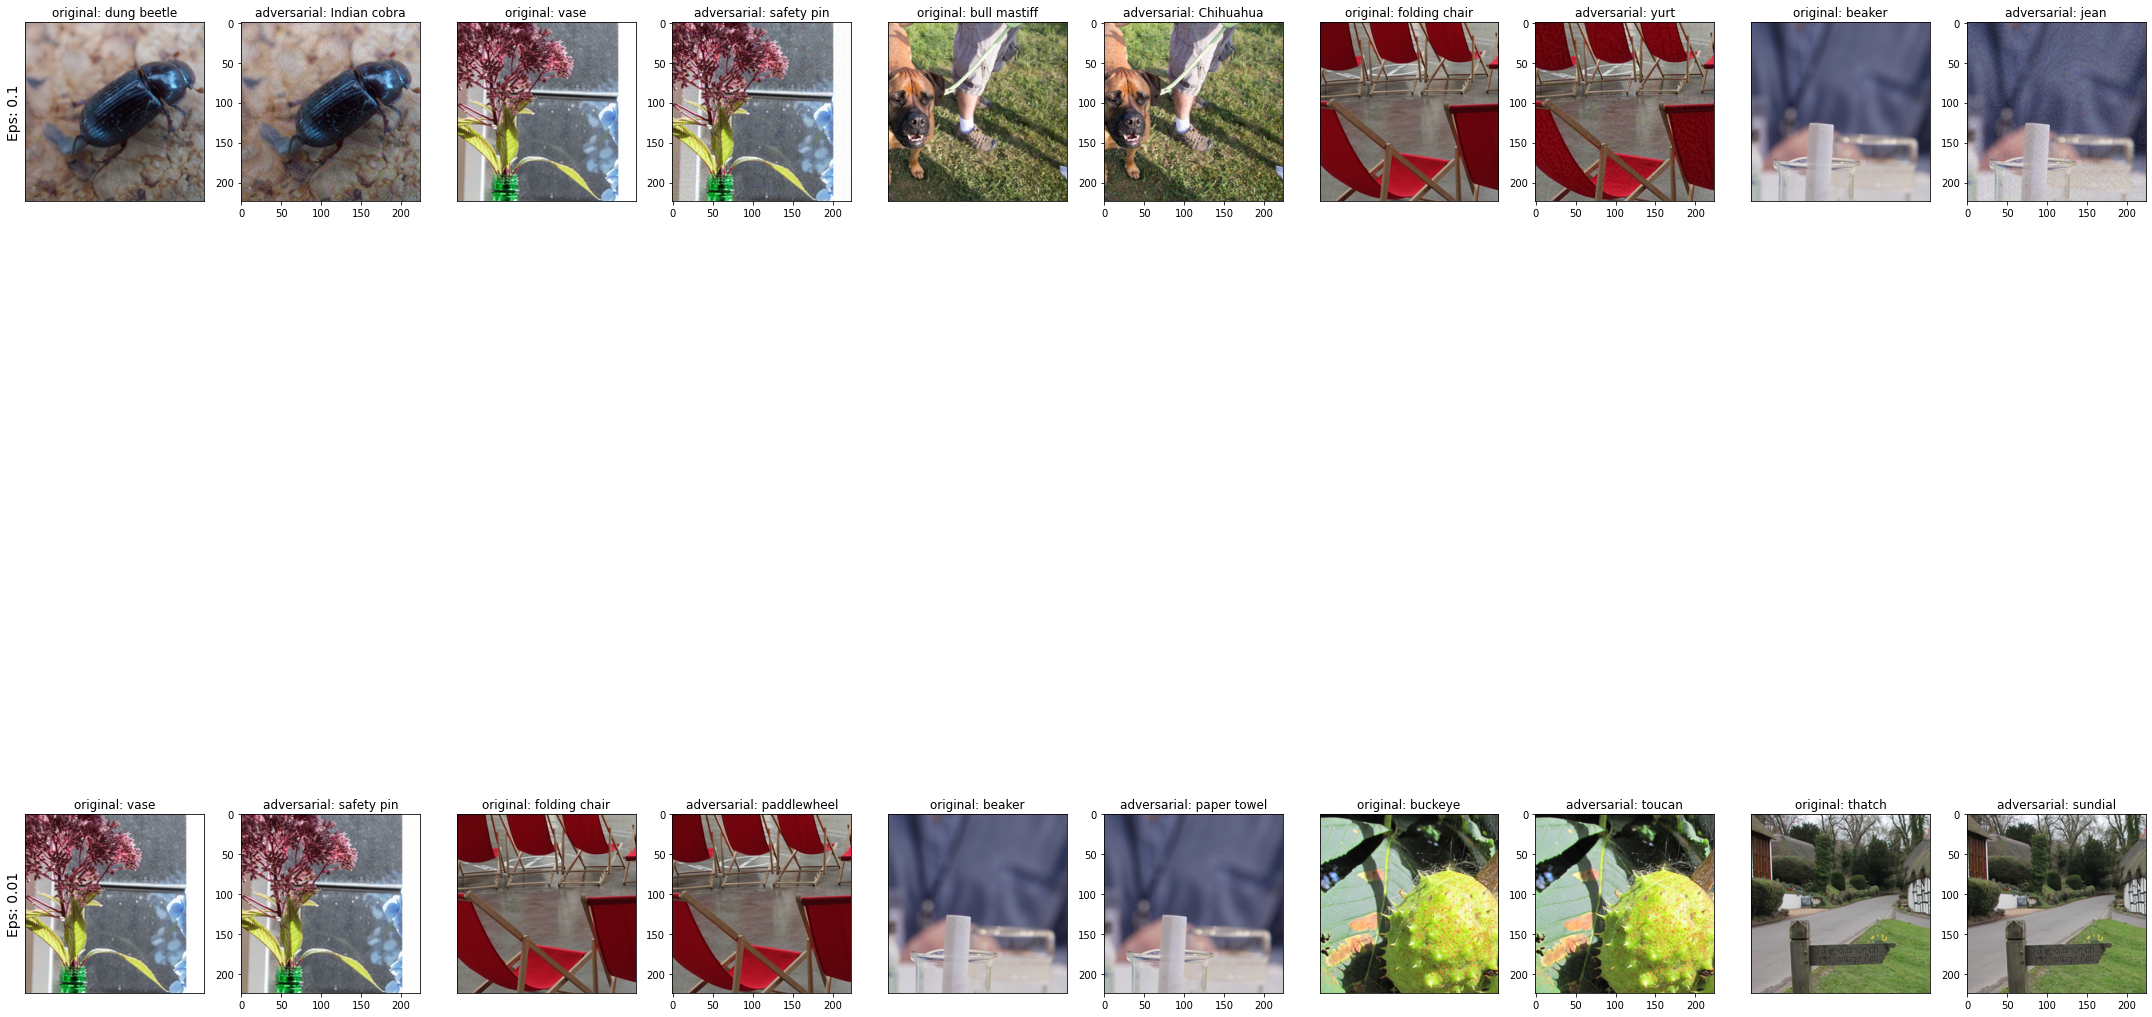

In [10]:
cnt = 0
plt.figure(figsize=(30, 30))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]) * 2,cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,orig_img, ex = examples[i][j]
        # plt.title("{} -> {}".format(orig, adv))
        plt.title("original: {}".format(label_name[orig].split(',')[0]))
        orig_img = np.transpose(orig_img, (1, 2, 0))
        plt.imshow(orig_img)
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]) * 2,cnt)
        plt.title("adversarial: {}".format(label_name[adv].split(',')[0]))
        ex = np.transpose(ex, (1, 2, 0))
        plt.imshow(ex)
plt.tight_layout()
plt.show()


In [ ]:
不要用wget下载，也不要用gdown、IDM，直接浏览器下载